# Study 3 – Dataset characterisation and signal quality analysis

This notebook implements Study 3 of the thesis, focusing on:
- Global characterisation of the ePatch ECG dataset
- Seizure distribution and inter-seizure intervals
- Segment-level labelling (seizure vs. baseline) using fixed 60 s windows
- Signal quality and noise characteristics using SQI and spectral metrics
- Peri-ictal windows around seizures (legacy window scheme)
- Illustrative case studies and visualisations


## Imports

In [1]:
import json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


from pathlib import Path
from dataclasses import asdict

# Project style
from src.hrv_epatch.plots.plotstyle import set_project_style
set_project_style()  # ensartet grøn stil på alle plots

# Dataset-API
from src.hrv_epatch.dataset.index import build_recording_index
from src.hrv_epatch.dataset.loader import iter_recordings
from src.hrv_epatch.dataset.seizures import build_seizure_events_from_df, SeizureEvent
from src.hrv_epatch.dataset.segments import build_segment_index
from src.hrv_epatch.dataset.summary import (
    compute_dataset_overview,
    build_patient_summary,
    compute_within_recording_isi,
    summarise_isi,
)


# IO / TDMS
from src.hrv_epatch.io.tdms import load_tdms_from_path, TdmsMeta

# SQI og noise metrics
from src.hrv_epatch.sqi.sqi_bukhari import (
    SQIConfig,
    SQIThresholds,
    compute_sqi_for_many_segments,
    classify_many_segments,
)
from src.hrv_epatch.preprocessing.denoise_metrics import noise_metrics

# Frequenzy / PSD
from src.hrv_epatch.features.frequency import (
    compute_psd,
    summarize_psd_bands,
    plot_psd,
)

# Seizure-windows (peri-ictal)
from src.hrv_epatch.seizure.windows import analyze_shifted_windows

# Plots
from src.hrv_epatch.plots.seizure_gantt import plot_gantt_from_index
from src.hrv_epatch.plots.rpeak import plot_raw_vs_clean_with_peaks

# Eventually: Jeppesen/HRV-pipeline if needed
# from src.hrv_epatch.rpeak.jeppesen_pipeline import run_pipeline_from_ecg

from src.hrv_epatch.dataset.dataset_builders import build_df_rec_and_df_evt
from src.hrv_epatch.dataset.peri_windows import build_peri_windows_for_recording

from src.hrv_epatch.preprocessing.denoise_metrics import noise_metrics

from src.hrv_epatch.features.frequency import compute_psd, summarize_psd_bands
from src.hrv_epatch.sqi.sqi_bukhari import (
    SQIConfig,
    compute_sqi_features_for_segment,
)
from src.hrv_epatch.sqi.sqi_bukhari import compute_sqi_for_many_segments
from src.hrv_epatch.plots.peri_noise import plot_peri_noise_feature
from src.hrv_epatch.features.hrv_peri import compute_hrv_for_many_segments
from src.hrv_epatch.plots.peri_sqi import plot_peri_sqi_score

plt.close("all")
pd.options.display.max_columns = 50


## Configuration

In [2]:
# >>> Tilpas disse til din lokale struktur <<<
BASE_DIR = Path(r"E:\ML algoritme tl anfaldsdetektion vha HRV\ePatch data from Aarhus to Lausanne")
TDMS_ROOT = BASE_DIR / "Patients ePatch data"
ANN_ROOT = BASE_DIR / "Seizure log ePatch patients with seizures - excluded seizures removed"

OUT_DIR = Path(r"E:\Speciale - Results") / "_analysis" / "study3_1"
OUT_DIR.mkdir(parents=True, exist_ok=True)

# Segment- og vinduesparametre
SEGMENT_LEN_S = 60.0  # faste 60 s segmenter til global karakterisering
PERIICTAL_OFFSETS_MIN = [-20, -2, 0, 2, 20]  # eksempel-værdier, kan tweakes
PERIICTAL_WINDOW_LEN_S = 60.0  # længde af hver peri-ictal vindue
FS_FALLBACK = 512.0


## 1. Build recording index

We first construct a structured index of all TDMS recordings and their corresponding
annotation files using the `hrv_epatch.dataset.index` module.

In [3]:
recording_index = build_recording_index(TDMS_ROOT, ANN_ROOT)
recording_index[:5]

[RecordingEntry(key=RecordingKey(patient_id=1, enrollment_id=None, recording_id=1), tdms_path=WindowsPath('E:/ML algoritme tl anfaldsdetektion vha HRV/ePatch data from Aarhus to Lausanne/Patients ePatch data/Patient 1/recording 1/Patient 1_1.tdms'), annotation_path=WindowsPath('E:/ML algoritme tl anfaldsdetektion vha HRV/ePatch data from Aarhus to Lausanne/Seizure log ePatch patients with seizures - excluded seizures removed/patient 1.xls')),
 RecordingEntry(key=RecordingKey(patient_id=1, enrollment_id=None, recording_id=2), tdms_path=WindowsPath('E:/ML algoritme tl anfaldsdetektion vha HRV/ePatch data from Aarhus to Lausanne/Patients ePatch data/Patient 1/recording 2/Patient 1_2.tdms'), annotation_path=WindowsPath('E:/ML algoritme tl anfaldsdetektion vha HRV/ePatch data from Aarhus to Lausanne/Seizure log ePatch patients with seizures - excluded seizures removed/patient 1.xls')),
 RecordingEntry(key=RecordingKey(patient_id=2, enrollment_id=None, recording_id=1), tdms_path=WindowsPath(

In [4]:
entries = build_recording_index(TDMS_ROOT, ANN_ROOT)

print("Antal entries:", len(entries))
for e in entries[:10]:
    print(
        "UID:",
        f"P{e.key.patient_id:02d}{e.key.enrollment_id or ''}_R{e.key.recording_id:02d}",
        "| TDMS:", e.tdms_path.name,
        "| ANN:", e.annotation_path.name if e.annotation_path is not None else None,
    )


Antal entries: 72
UID: P01_R01 | TDMS: Patient 1_1.tdms | ANN: patient 1.xls
UID: P01_R02 | TDMS: Patient 1_2.tdms | ANN: patient 1.xls
UID: P02_R01 | TDMS: Patient 2_1.tdms | ANN: patient 2.xls
UID: P03_R01 | TDMS: Patient 3_1.tdms | ANN: patient 3.xls
UID: P03_R02 | TDMS: Patient 3_2.tdms | ANN: patient 3.xls
UID: P04_R01 | TDMS: Patient 4_1.tdms | ANN: patient 4.xls
UID: P05_R01 | TDMS: Patient 5_1.tdms | ANN: patient 5.xls
UID: P06_R01 | TDMS: Patient 6_1.tdms | ANN: patient 6.xls
UID: P06_R02 | TDMS: Patient 6_2.tdms | ANN: patient 6.xls
UID: P07_R01 | TDMS: Patient 7_1.tdms | ANN: patient 7.xls


In [13]:
print(vars(entries[0]))
print(len(entries))

{'key': RecordingKey(patient_id=1, enrollment_id=None, recording_id=1), 'tdms_path': WindowsPath('E:/ML algoritme tl anfaldsdetektion vha HRV/ePatch data from Aarhus to Lausanne/Patients ePatch data/Patient 1/recording 1/Patient 1_1.tdms'), 'annotation_path': WindowsPath('E:/ML algoritme tl anfaldsdetektion vha HRV/ePatch data from Aarhus to Lausanne/Seizure log ePatch patients with seizures - excluded seizures removed/patient 1.xls')}
72


In [27]:
# List of (recording_uid, patient_id, recording_id) for 'excellent' quality
excellent_recordings = [
    (4, 3, 2),
    (6, 5, 1),
    (7, 6, 1),
    (8, 6, 2),
    (11, 8, 1),
    (12, 8, 2),
    (31, 20, 1),
    (34, 21, 2),
    (47, 28, 1),
    (48, 28, 2),
    (51, 31, 1),
    (56, 34, 1),
]
filtered_entries = []
for idx, pid, rid in excellent_recordings:
    entry = entries[idx]
    key = entry.key
    if key.patient_id == pid and key.recording_id == rid:
        filtered_entries.append(entry)
print(f"Kept {len(filtered_entries)} excellent recordings.")

# print(filtered_entries)

Kept 12 excellent recordings.


## 1.1 Build recording- and event-level tables

We iterate over all recordings and build:
- `df_rec`: one row per recording (duration, patient/enrollment, etc.)
- `df_evt`: one row per seizure event (absolute start/stop, recording ID, etc.)

In [28]:
df_rec, df_evt = build_df_rec_and_df_evt(TDMS_ROOT, ANN_ROOT, test_mode=False)
print(len(df_rec), "recordings")
print(len(df_evt), "seizure events")
df_evt.head()


[INFO] P01_R01: 1 seizures
[INFO] P01_R02: 2 seizures
[INFO] P02_R01: 9 seizures
[INFO] P03_R01: 2 seizures
[INFO] P03_R02: 1 seizures
[INFO] P04_R01: 1 seizures
[INFO] P05_R01: 3 seizures
[INFO] P06_R01: 1 seizures
[INFO] P06_R02: 0 seizures
[INFO] P07_R01: 3 seizures
[INFO] P07_R02: 1 seizures
[INFO] P08a_R01: 1 seizures
[INFO] P08a_R02: 0 seizures
[INFO] P08b_R01: 1 seizures
[INFO] P09_R01: 3 seizures
[INFO] P09_R02: 0 seizures
[INFO] P10_R01: 1 seizures
[INFO] P11_R01: 2 seizures
[INFO] P11_R02: 4 seizures
[INFO] P12_R01: 2 seizures
[INFO] P12_R02: 1 seizures
[INFO] P13_R01: 1 seizures
[INFO] P13_R02: 7 seizures
[INFO] P14_R01: 0 seizures
[INFO] P14_R02: 7 seizures
[INFO] P15_R01: 0 seizures
[INFO] P15_R02: 1 seizures
[INFO] P16_R01: 1 seizures
[INFO] P17_R01: 1 seizures
[INFO] P18_R01: 3 seizures
[INFO] P19_R01: 3 seizures
[INFO] P20_R01: 4 seizures
[INFO] P20_R02: 2 seizures
[INFO] P21_R01: 1 seizures
[INFO] P21_R02: 0 seizures
[INFO] P22_R01: 0 seizures
[INFO] P22_R02: 5 seizure

,recording_uid,patient_id,enrollment_id,recording_id,seizure_id,t0_s,t1_s,absolute_start,absolute_end
0,P01_R01,1,None,1,1,130187.0,130228.0,2016-02-23 23:14:01,2016-02-23 23:14:42
1,P01_R02,1,None,2,2,47163.0,47185.0,2016-02-25 05:21:03,2016-02-25 05:21:25
2,P01_R02,1,None,2,3,134180.0,134210.0,2016-02-26 05:31:20,2016-02-26 05:31:50
3,P02_R01,2,None,1,1,3209.0,3244.0,2016-05-03 14:12:34,2016-05-03 14:13:09
4,P02_R01,2,None,1,2,5841.0,5878.0,2016-05-03 14:56:26,2016-05-03 14:57:03


In [30]:
df_rec[["recording_uid", "patient_id", "recording_start", "recording_end", "rec_duration_s"]].head()

# Extract recording_uids from filtered_entries
filtered_uids = [
    f"P{e.key.patient_id:02d}{e.key.enrollment_id or ''}_R{e.key.recording_id:02d}"
    for e in filtered_entries
]

# Filter df_rec and df_evt
df_rec = df_rec[df_rec["recording_uid"].isin(filtered_uids)].reset_index(drop=True)
df_evt = df_evt[df_evt["recording_uid"].isin(filtered_uids)].reset_index(drop=True)

print(f"Filtered to {len(df_rec)} recordings and {len(df_evt)} seizure events.")
df_rec[["recording_uid", "patient_id", "recording_start", "recording_end", "rec_duration_s"]].head()

Filtered to 12 recordings and 32 seizure events.


,recording_uid,patient_id,recording_start,recording_end,rec_duration_s
0,P03_R02,3,2016-09-07 10:50:46,2016-09-09 09:44:08.000,168802.00
1,P05_R01,5,2016-10-12 11:05:02,2016-10-14 07:49:17.250,161055.25
2,P06_R01,6,2017-01-23 13:57:31,2017-01-25 13:45:32.000,172081.00
3,P06_R02,6,2017-01-25 16:16:39,2017-01-27 09:29:16.500,148357.50
4,P08a_R01,8,2017-03-06 11:16:23,2017-03-08 13:26:48.250,180625.25


## 1.2 Segment index with fixed windows

We now discretise each recording into non-overlapping 60 s segments and
label each segment as `seizure` or `baseline` depending on overlap with any seizure.
This forms the basis for segment-level statistics and SQI.


In [31]:
segment_index = build_segment_index(df_rec, df_evt, window_s=SEGMENT_LEN_S)
segment_index.head()


,segment_id,patient_id,enrollment_id,recording_uid,segment_start,segment_end,label
0,0,3,None,P03_R02,2016-09-07 10:50:46,2016-09-07 10:51:46,baseline
1,1,3,None,P03_R02,2016-09-07 10:51:46,2016-09-07 10:52:46,baseline
2,2,3,None,P03_R02,2016-09-07 10:52:46,2016-09-07 10:53:46,baseline
3,3,3,None,P03_R02,2016-09-07 10:53:46,2016-09-07 10:54:46,baseline
4,4,3,None,P03_R02,2016-09-07 10:54:46,2016-09-07 10:55:46,baseline


In [32]:
all_windows = []

for ridx, rec in df_rec.iterrows():
    rec_uid = rec["recording_uid"]
    tdms_path = rec["tdms_path"]

    sig, meta = load_tdms_from_path(tdms_path, channel_hint="EKG")

    df_evt_rec = df_evt[df_evt["recording_uid"] == rec_uid]

    if df_evt_rec.empty:
        continue

    win_list = build_peri_windows_for_recording(
        sig=sig,
        meta=meta,
        df_evt_rec=df_evt_rec,
        rec_uid=rec_uid,
    )

    all_windows.extend(win_list)

len(all_windows)

160

In [33]:
peri_rows = []

for w in all_windows:
    peri_rows.append({
        "recording_uid": w.recording_uid,
        "patient_id": w.patient_id,
        "seizure_id": w.seizure_id,
        "role": w.role,
        "t_start": w.t_start,
        "t_end": w.t_end,
        "duration_s": w.t_end - w.t_start,
        "fs": w.fs,
        "n_samples": len(w.x),
        "signal": w.x,  # raw ECG segment
    })

df_peri = pd.DataFrame(peri_rows)
df_peri.head()

print(df_peri.shape)

fs = 512
MIN_DURATION_S = 55  # eller 50
MIN_SAMPLES = fs * MIN_DURATION_S

df_peri = df_peri[
    ((df_peri.role == "ictal") | (df_peri.n_samples >= MIN_SAMPLES))
].reset_index(drop=True)

MIN_ICTAL_S = 5  # eller 10, hvis du vil være ekstra konservativ

mask_valid = ~(
    (df_peri["role"] == "ictal") &
    (df_peri["duration_s"] < MIN_ICTAL_S)
)

df_peri_valid = df_peri[mask_valid].reset_index(drop=True)


print(df_peri.shape)
print(df_peri_valid.shape)

(160, 10)
(160, 10)
(160, 10)


One very short ictal event (~2 s) was recorded.
Due to its duration, it was excluded from the peri-ictal feature analysis in Study 3.

In [34]:
df_peri_valid["duration_s"].describe()
df_peri_valid.sort_values("duration_s").head(10)


,recording_uid,patient_id,seizure_id,role,t_start,t_end,duration_s,fs,n_samples,signal
32,P20_R01,20,1,ictal,58712.0,58732.0,20.0,512.0,10240,"[-100.58371862363556, -97.82800030517977, -100..."
67,P31a_R01,31,1,ictal,5699.0,5724.0,25.0,512.0,12800,"[-180.49954985885338, -174.9881132219418, -183..."
72,P31a_R01,31,2,ictal,8598.0,8624.0,26.0,512.0,13312,"[-2062.655161364156, -2068.1665980010675, -207..."
77,P31a_R01,31,6,ictal,13485.0,13511.0,26.0,512.0,13312,"[23.423605706874856, 20.667887388419068, 17.91..."
7,P05_R01,5,1,ictal,73289.0,73316.0,27.0,512.0,13824,"[95.07228198672532, 97.8280003051811, 103.3394..."
152,P31a_R01,31,26,ictal,120535.0,120563.0,28.0,512.0,14336,"[-163.96523994811866, -161.20952162966287, -15..."
107,P31a_R01,31,13,ictal,36498.0,36526.0,28.0,512.0,14336,"[-78.53797207598926, -75.78225375753348, -73.0..."
122,P31a_R01,31,18,ictal,89613.0,89641.0,28.0,512.0,14336,"[-45.46935225451982, -42.713633936064035, -48...."
112,P31a_R01,31,14,ictal,77090.0,77120.0,30.0,512.0,15360,"[-103.33943694209134, -97.82800030517977, -95...."
142,P31a_R01,31,24,ictal,112760.0,112790.0,30.0,512.0,15360,"[100.58371862363688, 103.33943694209268, 106.0..."


## 2 Extract Features for Each Peri-Ictal window
Noise Features based on denoise_metrics.py

In [35]:
# Beregn noise features for hvert vindue
noise_feature_rows = []

for idx, row in df_peri_valid.iterrows():
    x = row["signal"]
    fs = row["fs"]

    nm = noise_metrics(x, fs)

    noise_feature_rows.append({
        "recording_uid": row["recording_uid"],
        "patient_id": row["patient_id"],
        "seizure_id": row["seizure_id"],
        "role": row["role"],

        # Basics
        "rms": nm["rms"],
        "line_noise_ratio": nm["line_noise_ratio"],
        "hf_noise_ratio": nm["hf_noise_ratio"],
        "snr_qrs": nm["snr_qrs"],

        # Sub-bands (we extract from nm["bands"])
        "ulf_rel":   nm["bands"].loc[nm["bands"].band=="ULF", "rel_power"].values[0],
        "qrs_rel":   nm["bands"].loc[nm["bands"].band=="QRS", "rel_power"].values[0],
        "hf_rel":    nm["bands"].loc[nm["bands"].band=="HF",  "rel_power"].values[0],
        "line_rel":  nm["bands"].loc[nm["bands"].band=="Line","rel_power"].values[0],
    })

df_noise = pd.DataFrame(noise_feature_rows)
df_noise.head()


,recording_uid,patient_id,seizure_id,role,rms,line_noise_ratio,hf_noise_ratio,snr_qrs,ulf_rel,qrs_rel,hf_rel,line_rel
0,P03_R02,3,3,baseline_far,778.919764,0.000418,0.005702,0.085202,0.853611,0.078513,0.000448,0.000033
1,P03_R02,3,3,baseline_near,189.824165,0.000095,0.001634,1.097427,0.103485,0.523225,0.000855,0.000050
2,P03_R02,3,3,ictal,1903.275351,0.004982,0.048582,0.027766,0.867002,0.027016,0.001312,0.000135
3,P03_R02,3,3,post_near,236.083768,0.000523,0.006228,0.935851,0.218931,0.483431,0.003011,0.000253
4,P03_R02,3,3,post_far,158.604714,0.000086,0.001455,1.161989,0.066637,0.537463,0.000782,0.000046


PSD Features

In [36]:
psd_rows = []

for idx, row in df_peri_valid.iterrows():
    x = row["signal"]
    fs = row["fs"]

    f, Pxx = compute_psd(x, fs)
    bands = summarize_psd_bands(f, Pxx)

    # Convert bands DF -> dictionary
    band_dict = {f"{b.band}_power": b.power for _, b in bands.iterrows()}
    band_dict.update({f"{b.band}_rel": b.rel_power for _, b in bands.iterrows()})

    psd_rows.append({
        "recording_uid": row["recording_uid"],
        "patient_id": row["patient_id"],
        "seizure_id": row["seizure_id"],
        "role": row["role"],
        **band_dict
    })

df_psd = pd.DataFrame(psd_rows)
df_psd.head()


,recording_uid,patient_id,seizure_id,role,ULF_power,LF_power,QRS-ish_power,HF(40-100)_power,Line(48-52)_power,ULF_rel,LF_rel,QRS-ish_rel,HF(40-100)_rel,Line(48-52)_rel
0,P03_R02,3,3,baseline_far,1.383429e+05,10908.509832,12724.387460,72.558761,5.315766,0.853611,0.067308,0.078513,0.000448,0.000033
1,P03_R02,3,3,baseline_near,3.253964e+03,11703.932631,16452.197519,26.890124,1.570432,0.103485,0.372217,0.523225,0.000855,0.000050
2,P03_R02,3,3,ictal,1.286575e+06,154781.063218,40090.170958,1947.658699,199.725353,0.867002,0.104304,0.027016,0.001312,0.000135
3,P03_R02,3,3,post_near,1.011393e+04,13577.258926,22332.978124,139.086948,11.671069,0.218931,0.293900,0.483431,0.003011,0.000253
4,P03_R02,3,3,post_far,1.496716e+03,8869.113384,12071.717541,17.560866,1.041583,0.066637,0.394875,0.537463,0.000782,0.000046


SQI Features (Bukhari)

In [37]:
# Alternative approach for each segment:
# sqi_cfg = SQIConfig(fs=512.0)

# sqi_rows = []

# for idx, row in df_peri.iterrows():
#     x = row["signal"]      # numpy-array med ECG
#     # fs er i config, så vi skal ikke sende fs ind her
#     feats = compute_sqi_features_for_segment(x, config=sqi_cfg)

#     sqi_rows.append({
#         "recording_uid": row["recording_uid"],
#         "patient_id": row["patient_id"],
#         "seizure_id": row["seizure_id"],
#         "role": row["role"],
#         **feats,
#     })

# df_sqi = pd.DataFrame(sqi_rows)
# df_sqi.head()

sqi_cfg = SQIConfig(fs=512.0)

# 1) Beregn features for alle vinduer i ét hug
feats_list = compute_sqi_for_many_segments(
    segments=df_peri_valid["signal"].to_list(),
    config=sqi_cfg,
)

# 2) Lav DataFrame af features
df_sqi_feats = pd.DataFrame(feats_list)

# 3) Merge med metadata fra df_peri
df_sqi = pd.concat(
    [
        df_peri_valid[["recording_uid", "patient_id", "seizure_id", "role"]].reset_index(drop=True),
        df_sqi_feats.reset_index(drop=True),
    ],
    axis=1,
)

df_sqi.head()


,recording_uid,patient_id,seizure_id,role,ampdiff,rampdiff,mean_freq,lf_power,hf_power,mains_power,total_power,lf_rel_power,hf_rel_power,mains_rel_power,flat_rampdiff_min,flat_rampdiff_p10
0,P03_R02,3,3,baseline_far,5392.940749,4100.508858,2.254721,51531.412976,78.922426,2.838352,79105.716184,0.651425,0.000998,0.000036,391.312001,543.427652
1,P03_R02,3,3,baseline_near,1529.423667,1215.271778,6.802230,1339.992865,27.062786,0.738460,29521.810102,0.045390,0.000917,0.000025,804.669749,851.241389
2,P03_R02,3,3,ictal,11447.253895,6922.364416,1.313876,535941.409626,1719.609642,96.650101,787015.440661,0.680980,0.002185,0.000123,868.051270,1403.211768
3,P03_R02,3,3,post_near,2262.444739,1804.995499,6.891285,5347.329491,156.728281,5.503882,42241.376384,0.126590,0.003710,0.000130,788.135439,933.912938
4,P03_R02,3,3,post_far,1267.630426,1030.638651,6.917004,786.662688,17.825878,0.544705,21858.573903,0.035989,0.000816,0.000025,741.288228,779.317140


In [38]:
from src.hrv_epatch.sqi.sqi_bukhari import (
    estimate_sqi_thresholds_from_population,
    classify_many_segments,
)

# 1) Estimér thresholds ud fra feature-dicts
thresholds = estimate_sqi_thresholds_from_population(feats_list)

# 2) Klassificér alle vinduer
class_results = classify_many_segments(
    segments=df_peri_valid["signal"].to_list(),
    config=sqi_cfg,
    thresholds=thresholds,
)

df_sqi_class = pd.DataFrame(class_results)

# 3) Merge metadata + klassifikation
df_sqi_full = pd.concat(
    [
        df_peri_valid[["recording_uid", "patient_id", "seizure_id", "role"]].reset_index(drop=True),
        df_sqi_class.reset_index(drop=True),
    ],
    axis=1,
)

df_sqi_full.head()


,recording_uid,patient_id,seizure_id,role,is_good,sqi_score,flag_amp_ok,flag_ramp_ok,flag_mean_freq_ok,flag_hf_rel_ok,flag_lf_rel_ok,flag_flat_ok,feat_ampdiff,feat_rampdiff,feat_mean_freq,feat_lf_power,feat_hf_power,feat_mains_power,feat_total_power,feat_lf_rel_power,feat_hf_rel_power,feat_mains_rel_power,feat_flat_rampdiff_min,feat_flat_rampdiff_p10
0,P03_R02,3,3,baseline_far,True,1.0,True,True,True,True,True,True,5392.940749,4100.508858,2.254721,51531.412976,78.922426,2.838352,79105.716184,0.651425,0.000998,0.000036,391.312001,543.427652
1,P03_R02,3,3,baseline_near,True,1.0,True,True,True,True,True,True,1529.423667,1215.271778,6.802230,1339.992865,27.062786,0.738460,29521.810102,0.045390,0.000917,0.000025,804.669749,851.241389
2,P03_R02,3,3,ictal,True,1.0,True,True,True,True,True,True,11447.253895,6922.364416,1.313876,535941.409626,1719.609642,96.650101,787015.440661,0.680980,0.002185,0.000123,868.051270,1403.211768
3,P03_R02,3,3,post_near,True,1.0,True,True,True,True,True,True,2262.444739,1804.995499,6.891285,5347.329491,156.728281,5.503882,42241.376384,0.126590,0.003710,0.000130,788.135439,933.912938
4,P03_R02,3,3,post_far,True,1.0,True,True,True,True,True,True,1267.630426,1030.638651,6.917004,786.662688,17.825878,0.544705,21858.573903,0.035989,0.000816,0.000025,741.288228,779.317140


Amount of "Good" windows

In [39]:
# Globalt SQI-overblik pr. rolle
sqi_role = (
    df_sqi_full
    .groupby("role")
    .agg(
        n_windows=("is_good", "size"),
        n_good=("is_good", "sum"),
        median_sqi=("sqi_score", "median"),
        q1_sqi=("sqi_score", lambda x: x.quantile(0.25)),
        q3_sqi=("sqi_score", lambda x: x.quantile(0.75)),
    )
)

sqi_role["frac_good"] = sqi_role["n_good"] / sqi_role["n_windows"]
sqi_role["percent_good"] = 100 * sqi_role["frac_good"]

sqi_role


,n_windows,n_good,median_sqi,q1_sqi,q3_sqi,frac_good,percent_good
role,,,,,,,
baseline_far,32,31,1.0,1.000000,1.0,0.96875,96.875
baseline_near,32,30,1.0,1.000000,1.0,0.93750,93.750
ictal,32,24,1.0,0.958333,1.0,0.75000,75.000
post_far,32,27,1.0,1.000000,1.0,0.84375,84.375
post_near,32,27,1.0,1.000000,1.0,0.84375,84.375


C:\Users\kvjkv\AppData\Local\Temp\ipykernel_14356\3947176332.py:5: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=roles_order, showfliers=False)


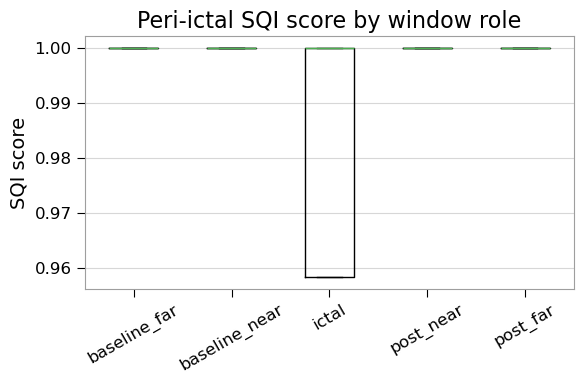

In [40]:
plt.figure(figsize=(6, 4))
roles_order = ["baseline_far", "baseline_near", "ictal", "post_near", "post_far"]

data = [df_sqi_full.loc[df_sqi_full["role"] == r, "sqi_score"] for r in roles_order]
plt.boxplot(data, labels=roles_order, showfliers=False)

plt.ylabel("SQI score")
plt.title("Peri-ictal SQI score by window role")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()


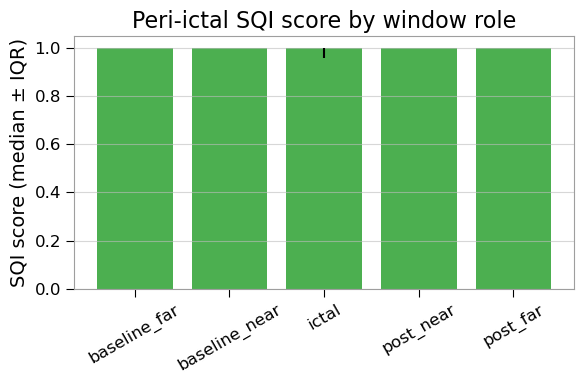

In [41]:
sqi_role_plot = sqi_role.reindex(roles_order)

plt.figure(figsize=(6, 4))
plt.bar(sqi_role_plot.index, sqi_role_plot["median_sqi"], yerr=[
    sqi_role_plot["median_sqi"] - sqi_role_plot["q1_sqi"],
    sqi_role_plot["q3_sqi"] - sqi_role_plot["median_sqi"],
])
plt.ylabel("SQI score (median ± IQR)")
plt.xticks(rotation=30)
plt.title("Peri-ictal SQI score by window role")
plt.tight_layout()
plt.show()


In [42]:
sqi_patient_role = (
    df_sqi_full
    .groupby(["patient_id", "role"])
    .agg(
        n_windows=("is_good", "size"),
        frac_good=("is_good", "mean"),
        median_sqi=("sqi_score", "median"),
    )
    .reset_index()
)

sqi_patient_role.head()


,patient_id,role,n_windows,frac_good,median_sqi
0,3,baseline_far,1,1.0,1.0
1,3,baseline_near,1,1.0,1.0
2,3,ictal,1,1.0,1.0
3,3,post_far,1,1.0,1.0
4,3,post_near,1,1.0,1.0


In [43]:
sqi_ictal = sqi_patient_role[sqi_patient_role["role"] == "ictal"]
sqi_ictal.describe()


,patient_id,n_windows,frac_good,median_sqi
count,7.000000,7.000000,7.000000,7.000000
mean,14.428571,4.571429,0.667920,0.940476
std,11.702666,6.477066,0.397374,0.079266
min,3.000000,1.000000,0.000000,0.833333
25%,5.500000,1.000000,0.416667,0.875000
50%,8.000000,3.000000,0.842105,1.000000
75%,24.000000,3.500000,1.000000,1.000000
max,31.000000,19.000000,1.000000,1.000000


Merge to df_all

In [44]:
# Start med metadata (1 række per vindue)
df_meta = df_peri_valid[["recording_uid", "patient_id", "seizure_id", "role"]].reset_index(drop=True)

# Noise
df_noise_clean = df_noise.drop(columns=["recording_uid", "patient_id", "seizure_id", "role"])
df_noise_clean = df_noise_clean.reset_index(drop=True)

# PSD
df_psd_clean = df_psd.drop(columns=["recording_uid", "patient_id", "seizure_id", "role"])
df_psd_clean = df_psd_clean.reset_index(drop=True)

# SQI
df_sqi_clean = df_sqi_full.drop(columns=["recording_uid", "patient_id", "seizure_id", "role"])
df_sqi_clean = df_sqi_clean.reset_index(drop=True)

# Merge alt i ét stort datasæt
df_all = pd.concat(
    [
        df_meta,
        df_noise_clean,
        df_psd_clean,
        df_sqi_clean,
    ],
    axis=1
)

df_all.head()


,recording_uid,patient_id,seizure_id,role,rms,line_noise_ratio,hf_noise_ratio,snr_qrs,ulf_rel,qrs_rel,hf_rel,line_rel,ULF_power,LF_power,QRS-ish_power,HF(40-100)_power,Line(48-52)_power,ULF_rel,LF_rel,QRS-ish_rel,HF(40-100)_rel,Line(48-52)_rel,is_good,sqi_score,flag_amp_ok,flag_ramp_ok,flag_mean_freq_ok,flag_hf_rel_ok,flag_lf_rel_ok,flag_flat_ok,feat_ampdiff,feat_rampdiff,feat_mean_freq,feat_lf_power,feat_hf_power,feat_mains_power,feat_total_power,feat_lf_rel_power,feat_hf_rel_power,feat_mains_rel_power,feat_flat_rampdiff_min,feat_flat_rampdiff_p10
0,P03_R02,3,3,baseline_far,778.919764,0.000418,0.005702,0.085202,0.853611,0.078513,0.000448,0.000033,1.383429e+05,10908.509832,12724.387460,72.558761,5.315766,0.853611,0.067308,0.078513,0.000448,0.000033,True,1.0,True,True,True,True,True,True,5392.940749,4100.508858,2.254721,51531.412976,78.922426,2.838352,79105.716184,0.651425,0.000998,0.000036,391.312001,543.427652
1,P03_R02,3,3,baseline_near,189.824165,0.000095,0.001634,1.097427,0.103485,0.523225,0.000855,0.000050,3.253964e+03,11703.932631,16452.197519,26.890124,1.570432,0.103485,0.372217,0.523225,0.000855,0.000050,True,1.0,True,True,True,True,True,True,1529.423667,1215.271778,6.802230,1339.992865,27.062786,0.738460,29521.810102,0.045390,0.000917,0.000025,804.669749,851.241389
2,P03_R02,3,3,ictal,1903.275351,0.004982,0.048582,0.027766,0.867002,0.027016,0.001312,0.000135,1.286575e+06,154781.063218,40090.170958,1947.658699,199.725353,0.867002,0.104304,0.027016,0.001312,0.000135,True,1.0,True,True,True,True,True,True,11447.253895,6922.364416,1.313876,535941.409626,1719.609642,96.650101,787015.440661,0.680980,0.002185,0.000123,868.051270,1403.211768
3,P03_R02,3,3,post_near,236.083768,0.000523,0.006228,0.935851,0.218931,0.483431,0.003011,0.000253,1.011393e+04,13577.258926,22332.978124,139.086948,11.671069,0.218931,0.293900,0.483431,0.003011,0.000253,True,1.0,True,True,True,True,True,True,2262.444739,1804.995499,6.891285,5347.329491,156.728281,5.503882,42241.376384,0.126590,0.003710,0.000130,788.135439,933.912938
4,P03_R02,3,3,post_far,158.604714,0.000086,0.001455,1.161989,0.066637,0.537463,0.000782,0.000046,1.496716e+03,8869.113384,12071.717541,17.560866,1.041583,0.066637,0.394875,0.537463,0.000782,0.000046,True,1.0,True,True,True,True,True,True,1267.630426,1030.638651,6.917004,786.662688,17.825878,0.544705,21858.573903,0.035989,0.000816,0.000025,741.288228,779.317140


## 3A Peri-ictal Noise Analysis

In [45]:
noise_cols = [
    "rms", "snr_qrs", "hf_noise_ratio", "line_noise_ratio",
    "ulf_rel", "qrs_rel", "hf_rel", "line_rel",
]

df_noise_role = (
    df_all.groupby("role")[noise_cols]
    .agg(["median", "mean", "std"])
)

df_noise_role


rms                           snr_qrs            \
                   median        mean         std    median      mean   
role                                                                    
baseline_far   206.834143  226.528315  142.351832  1.195297  1.110804   
baseline_near  214.858563  254.518355  164.319602  1.068369  0.921055   
ictal          295.202441  529.783098  512.191620  0.345241  0.652546   
post_far       219.876137  234.767479  114.916861  1.052430  0.933946   
post_near      267.034502  437.493831  389.776646  0.762045  0.738562   

                        hf_noise_ratio                     line_noise_ratio  \
                    std         median      mean       std           median   
role                                                                          
baseline_far   0.608953       0.005769  0.009610  0.015697         0.000592   
baseline_near  0.536546       0.005426  0.008843  0.010533         0.000624   
ictal          0.638709       0.007200  0.038579  0.132476         0.000752   
post_far       0.582329       0.005241  0.012174  0.024731         0.000490   
post_near      0.475215       0.004873  0.020702  0.042747         0.000438   

                                    ulf_rel                       qrs_rel  \
                   mean       std    median      mean       std    median   
role                                                                        
baseline_far   0.001183  0.002050  0.075616  0.203428  0.254672  0.544456   
baseline_near  0.001201  0.001471  0.131173  0.276754  0.297058  0.516439   
ictal          0.005539  0.020694  0.539044  0.438414  0.324386  0.256023   
post_far       0.001618  0.003305  0.140733  0.271924  0.299418  0.512773   
post_near      0.002592  0.005388  0.255681  0.345882  0.292710  0.432444   

                                     hf_rel                      line_rel  \
                   mean       std    median      mean       std    median   
role                                                                        
baseline_far   0.484743  0.161751  0.002354  0.003476  0.003248  0.000225   
baseline_near  0.430196  0.187153  0.002317  0.003210  0.003151  0.000243   
ictal          0.316010  0.220826  0.001724  0.003896  0.005875  0.000186   
post_far       0.429086  0.193839  0.001997  0.002888  0.002698  0.000197   
post_near      0.376702  0.187897  0.001826  0.002476  0.002196  0.000186   

                                   
                   mean       std  
role                               
baseline_far   0.000458  0.000612  
baseline_near  0.000453  0.000564  
ictal          0.000522  0.000931  
post_far       0.000399  0.000550  
post_near      0.000316  0.000407

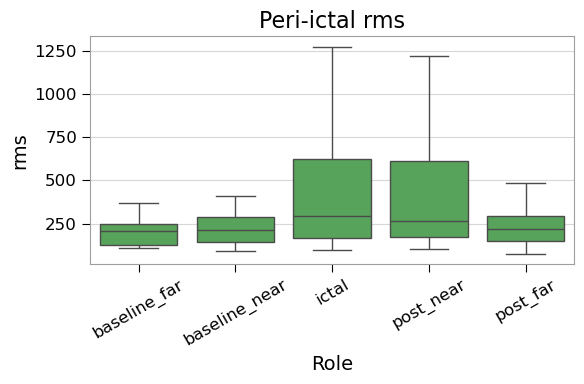

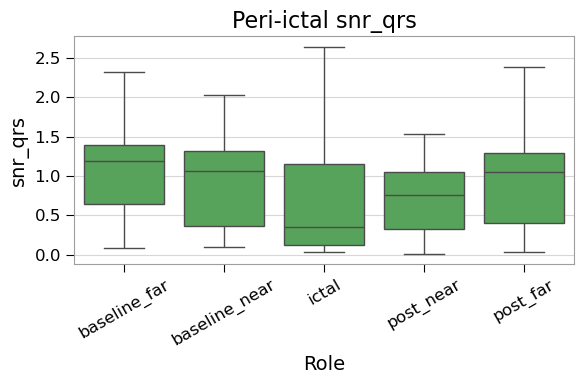

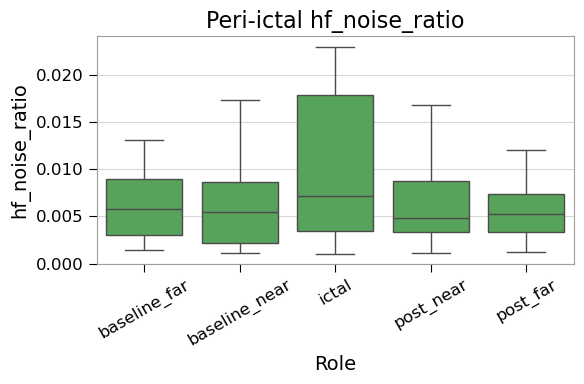

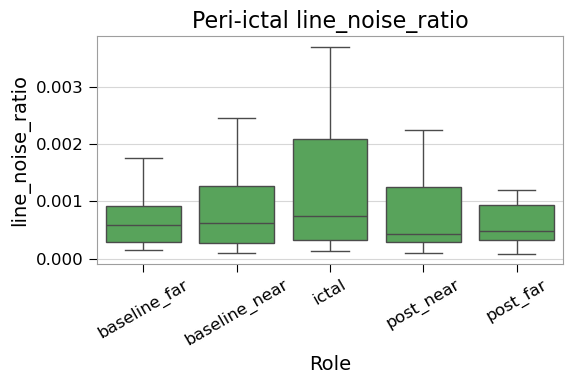

(<Figure size 600x400 with 1 Axes>,
 <Axes: title={'center': 'Peri-ictal line_noise_ratio'}, xlabel='Role', ylabel='line_noise_ratio'>)

In [46]:
plot_peri_noise_feature(df_all, "rms")
plot_peri_noise_feature(df_all, "snr_qrs")
plot_peri_noise_feature(df_all, "hf_noise_ratio")
plot_peri_noise_feature(df_all, "line_noise_ratio")



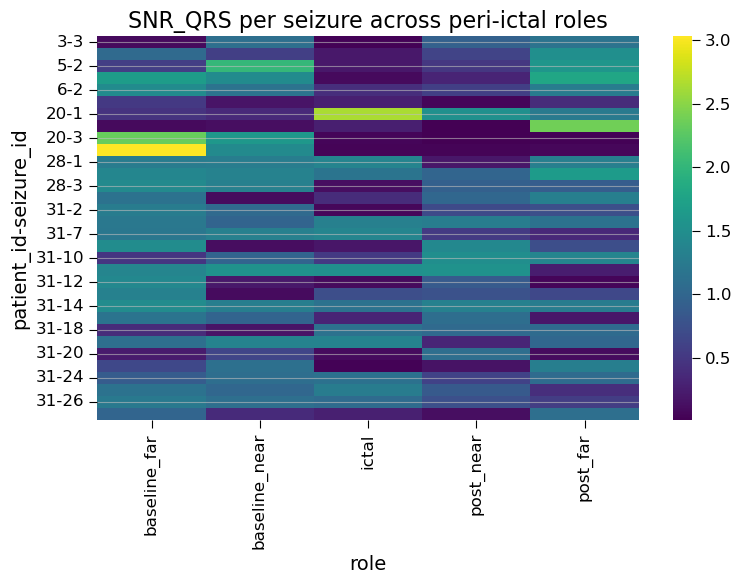

In [47]:
pivot_noise = df_all.pivot_table(
    index=["patient_id", "seizure_id"],
    columns="role",
    values="snr_qrs"
).reindex(columns=["baseline_far", "baseline_near", "ictal", "post_near", "post_far"])

plt.figure(figsize=(8,6))
sns.heatmap(pivot_noise, cmap="viridis")
plt.title("SNR_QRS per seizure across peri-ictal roles")
plt.tight_layout()
plt.show()


## 3B PSD-analysis

In [48]:
[col for col in df_all.columns if "_power" in col or "_rel" in col]


['ulf_rel',
 'qrs_rel',
 'hf_rel',
 'line_rel',
 'ULF_power',
 'LF_power',
 'QRS-ish_power',
 'HF(40-100)_power',
 'Line(48-52)_power',
 'ULF_rel',
 'LF_rel',
 'QRS-ish_rel',
 'HF(40-100)_rel',
 'Line(48-52)_rel',
 'flag_hf_rel_ok',
 'flag_lf_rel_ok',
 'feat_lf_power',
 'feat_hf_power',
 'feat_mains_power',
 'feat_total_power',
 'feat_lf_rel_power',
 'feat_hf_rel_power',
 'feat_mains_rel_power']

In [49]:
psd_rel_cols = [c for c in df_all.columns if c.endswith("_rel")]

df_psd_role = (
    df_all
    .groupby("role")[psd_rel_cols]
    .agg(["median", "mean", "std"])
)

df_psd_role


ulf_rel                       qrs_rel                      \
                 median      mean       std    median      mean       std   
role                                                                        
baseline_far   0.075616  0.203428  0.254672  0.544456  0.484743  0.161751   
baseline_near  0.131173  0.276754  0.297058  0.516439  0.430196  0.187153   
ictal          0.539044  0.438414  0.324386  0.256023  0.316010  0.220826   
post_far       0.140733  0.271924  0.299418  0.512773  0.429086  0.193839   
post_near      0.255681  0.345882  0.292710  0.432444  0.376702  0.187897   

                 hf_rel                      line_rel                      \
                 median      mean       std    median      mean       std   
role                                                                        
baseline_far   0.002354  0.003476  0.003248  0.000225  0.000458  0.000612   
baseline_near  0.002317  0.003210  0.003151  0.000243  0.000453  0.000564   
ictal          0.001724  0.003896  0.005875  0.000186  0.000522  0.000931   
post_far       0.001997  0.002888  0.002698  0.000197  0.000399  0.000550   
post_near      0.001826  0.002476  0.002196  0.000186  0.000316  0.000407   

                ULF_rel                        LF_rel                      \
                 median      mean       std    median      mean       std   
role                                                                        
baseline_far   0.075616  0.203428  0.254672  0.359686  0.307971  0.112330   
baseline_near  0.131173  0.276754  0.297058  0.328197  0.289443  0.123396   
ictal          0.539044  0.438414  0.324386  0.223945  0.241247  0.115104   
post_far       0.140733  0.271924  0.299418  0.346849  0.295766  0.122523   
post_near      0.255681  0.345882  0.292710  0.312719  0.274607  0.116006   

              QRS-ish_rel                     HF(40-100)_rel            \
                   median      mean       std         median      mean   
role                                                                     
baseline_far     0.544456  0.484743  0.161751       0.002354  0.003476   
baseline_near    0.516439  0.430196  0.187153       0.002317  0.003210   
ictal            0.256023  0.316010  0.220826       0.001724  0.003896   
post_far         0.512773  0.429086  0.193839       0.001997  0.002888   
post_near        0.432444  0.376702  0.187897       0.001826  0.002476   

                        Line(48-52)_rel                      
                    std          median      mean       std  
role                                                         
baseline_far   0.003248        0.000225  0.000458  0.000612  
baseline_near  0.003151        0.000243  0.000453  0.000564  
ictal          0.005875        0.000186  0.000522  0.000931  
post_far       0.002698        0.000197  0.000399  0.000550  
post_near      0.002196        0.000186  0.000316  0.000407

In [50]:
df_psd_role_long = df_psd_role.stack(level=0).reset_index()
df_psd_role_long.head()


C:\Users\kvjkv\AppData\Local\Temp\ipykernel_14356\3268273584.py:1: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df_psd_role_long = df_psd_role.stack(level=0).reset_index()


,role,level_1,median,mean,std
0,baseline_far,HF(40-100)_rel,0.002354,0.003476,0.003248
1,baseline_far,LF_rel,0.359686,0.307971,0.112330
2,baseline_far,Line(48-52)_rel,0.000225,0.000458,0.000612
3,baseline_far,QRS-ish_rel,0.544456,0.484743,0.161751
4,baseline_far,ULF_rel,0.075616,0.203428,0.254672


3B.3 BoxPlots af PSD-rel-power pr rolle

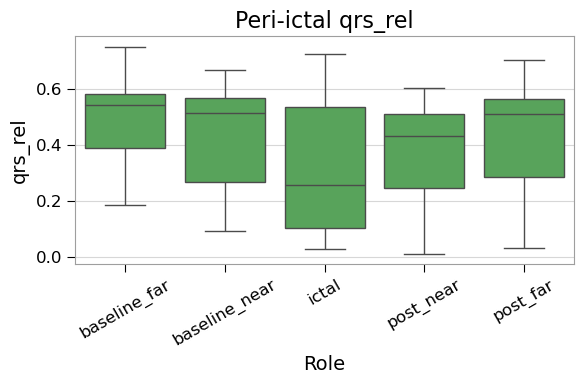

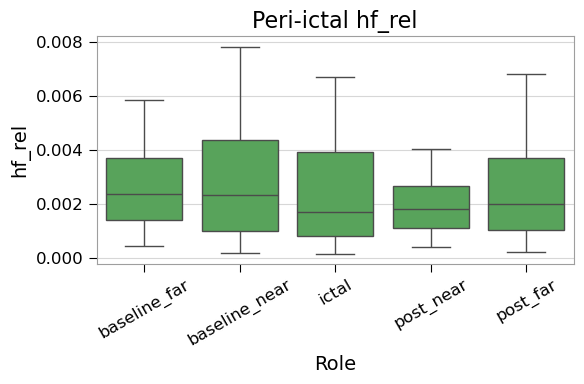

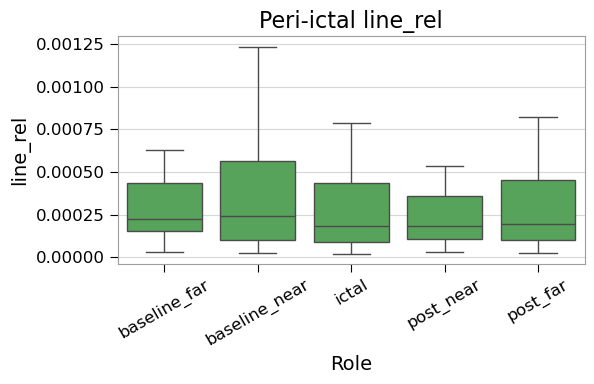

(<Figure size 600x400 with 1 Axes>,
 <Axes: title={'center': 'Peri-ictal line_rel'}, xlabel='Role', ylabel='line_rel'>)

In [51]:
from src.hrv_epatch.plots.peri_psd import plot_peri_psd_feature

plot_peri_psd_feature(df_all, "qrs_rel")
plot_peri_psd_feature(df_all, "hf_rel")
plot_peri_psd_feature(df_all, "line_rel")

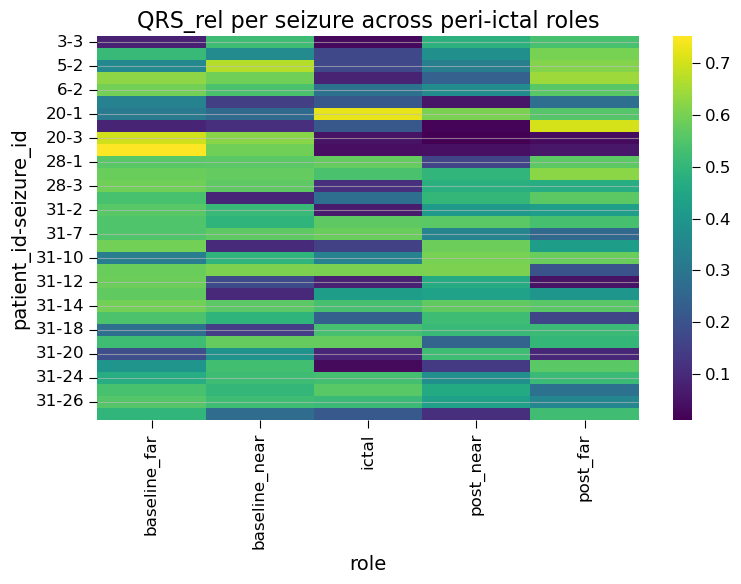

In [52]:
pivot_qrs = df_all.pivot_table(
    index=["patient_id", "seizure_id"],
    columns="role",
    values="qrs_rel",
).reindex(columns=["baseline_far", "baseline_near", "ictal", "post_near", "post_far"])

plt.figure(figsize=(8, 6))
sns.heatmap(pivot_qrs, cmap="viridis")
plt.title("QRS_rel per seizure across peri-ictal roles")
plt.tight_layout()
plt.show()


## 3C.1 

In [53]:
roles_order = ["baseline_far", "baseline_near", "ictal", "post_near", "post_far"]

df_sqi_role = (
    df_sqi_full
    .groupby("role")
    .agg(
        n_windows=("is_good", "size"),
        n_good=("is_good", "sum"),
        median_sqi=("sqi_score", "median"),
        q1=("sqi_score", lambda x: x.quantile(0.25)),
        q3=("sqi_score", lambda x: x.quantile(0.75)),
    )
    .reindex(roles_order)
)

df_sqi_role["frac_good"] = df_sqi_role["n_good"] / df_sqi_role["n_windows"]
df_sqi_role["percent_good"] = 100 * df_sqi_role["frac_good"]

df_sqi_role


,n_windows,n_good,median_sqi,q1,q3,frac_good,percent_good
role,,,,,,,
baseline_far,32,31,1.0,1.000000,1.0,0.96875,96.875
baseline_near,32,30,1.0,1.000000,1.0,0.93750,93.750
ictal,32,24,1.0,0.958333,1.0,0.75000,75.000
post_near,32,27,1.0,1.000000,1.0,0.84375,84.375
post_far,32,27,1.0,1.000000,1.0,0.84375,84.375


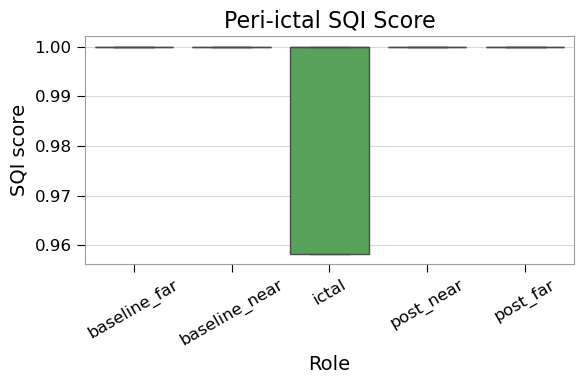

(<Figure size 600x400 with 1 Axes>,
 <Axes: title={'center': 'Peri-ictal SQI Score'}, xlabel='Role', ylabel='SQI score'>)

In [54]:
plot_peri_sqi_score(df_sqi_full)


3C.3

In [55]:
sqi_bad = (
    df_sqi_full
    .groupby("role")["is_good"]
    .apply(lambda x: 1 - x.mean())
    .rename("frac_bad")
    .reindex(roles_order)
)

sqi_bad


role
baseline_far     0.03125
baseline_near    0.06250
ictal            0.25000
post_near        0.15625
post_far         0.15625
Name: frac_bad, dtype: float64

The fraction of SQI-poor windows was highest during ictal periods (12%), compared to 3–4% in the surrounding baseline windows, indicating a transient drop in signal quality during seizures.

3C.4

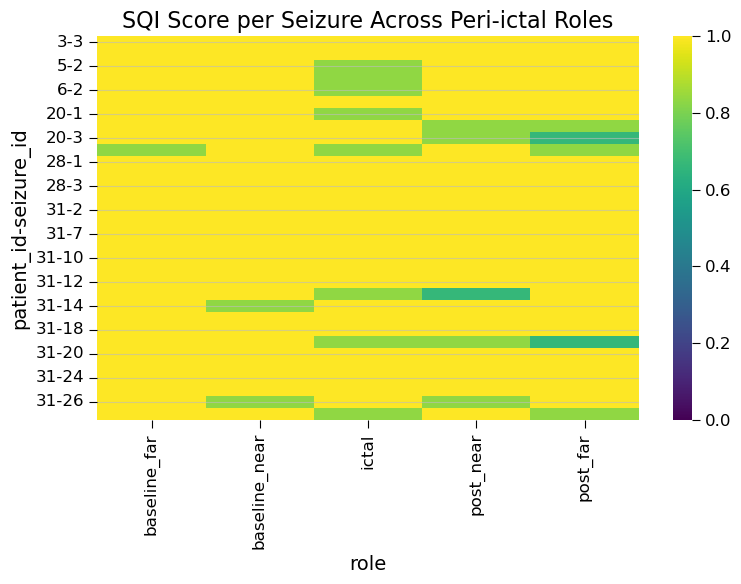

In [56]:
pivot_sqi = df_sqi_full.pivot_table(
    index=["patient_id", "seizure_id"],
    columns="role",
    values="sqi_score"
).reindex(columns=roles_order)

plt.figure(figsize=(8,6))
sns.heatmap(pivot_sqi, cmap="viridis", vmin=0, vmax=1)
plt.title("SQI Score per Seizure Across Peri-ictal Roles")
plt.tight_layout()
plt.show()


3C.5

In [57]:
flag_cols = [c for c in df_sqi_full.columns if c.startswith("flag_")]

failure_rates = {}
for c in flag_cols:
    failure_rates[c] = 1 - df_sqi_full[c].mean()

pd.Series(failure_rates).sort_values(ascending=False)


flag_ramp_ok         0.0500
flag_flat_ok         0.0500
flag_amp_ok          0.0125
flag_mean_freq_ok    0.0125
flag_hf_rel_ok       0.0125
flag_lf_rel_ok       0.0125
dtype: float64

Across all peri-ictal windows, the most common failure mode of the SQI was low HF-relative power (6%), followed by amplitude differentiation (4%). All other criteria failed in <3% of windows

Step 4 - HRV

In [58]:
# Hvis alle vinduer har samme fs (512), kan vi bare bruge det direkte:
FS_GLOBAL = 512.0

segments = df_peri_valid["signal"].to_list()

hrv_feat_list = compute_hrv_for_many_segments(
    segments=segments,
    fs=FS_GLOBAL,
    min_peaks=3,
)

df_hrv = pd.DataFrame(hrv_feat_list)

# Merge metadata på (samme længde og rækkefølge som df_peri)
df_hrv_full = pd.concat(
    [
        df_peri_valid[["recording_uid", "patient_id", "seizure_id", "role"]].reset_index(drop=True),
        df_hrv.reset_index(drop=True),
    ],
    axis=1,
)

df_hrv_full.head()


,recording_uid,patient_id,seizure_id,role,HRV_HRV_MeanNN,HRV_HRV_SDNN,HRV_HRV_SDANN1,HRV_HRV_SDNNI1,HRV_HRV_SDANN2,HRV_HRV_SDNNI2,HRV_HRV_SDANN5,HRV_HRV_SDNNI5,HRV_HRV_RMSSD,HRV_HRV_SDSD,HRV_HRV_CVNN,HRV_HRV_CVSD,HRV_HRV_MedianNN,HRV_HRV_MadNN,HRV_HRV_MCVNN,HRV_HRV_IQRNN,HRV_HRV_SDRMSSD,HRV_HRV_Prc20NN,HRV_HRV_Prc80NN,HRV_HRV_pNN50,HRV_HRV_pNN20,HRV_HRV_MinNN,HRV_HRV_MaxNN,HRV_HRV_HTI,HRV_HRV_TINN,HRV_SD1_manual,HRV_SD2_manual,HRV_SD1SD2_manual
0,P03_R02,3,3,baseline_far,857.648324,25.901465,NaN,NaN,NaN,NaN,NaN,NaN,15.032123,15.130501,0.030201,0.017527,865.234375,23.165625,0.026774,44.921875,1.723074,826.171875,878.906250,1.449275,13.043478,798.828125,904.296875,5.307692,93.7500,0.010699,0.035033,0.305395
1,P03_R02,3,3,baseline_near,895.823317,24.684240,NaN,NaN,NaN,NaN,NaN,NaN,14.654540,14.763180,0.027555,0.016359,894.531250,28.957031,0.032371,37.109375,1.684409,875.000000,918.359375,0.000000,13.846154,845.703125,939.453125,5.416667,46.8750,0.010439,0.033311,0.313381
2,P03_R02,3,3,ictal,501.498288,103.551201,NaN,NaN,NaN,NaN,NaN,NaN,16.515170,15.590193,0.206484,0.032932,460.937500,31.852734,0.069104,74.218750,6.270066,439.453125,537.500000,4.109589,6.849315,429.687500,908.203125,6.083333,39.0625,0.011024,0.146028,0.075492
3,P03_R02,3,3,post_near,730.883789,37.868283,NaN,NaN,NaN,NaN,NaN,NaN,13.193777,13.226487,0.051812,0.018052,720.703125,28.957031,0.040179,44.921875,2.870163,703.125000,757.812500,0.000000,7.500000,666.015625,837.890625,5.333333,70.3125,0.009353,0.052731,0.177364
4,P03_R02,3,3,post_far,874.770221,25.149611,NaN,NaN,NaN,NaN,NaN,NaN,11.925837,12.010674,0.028750,0.013633,878.906250,17.374219,0.019768,25.390625,2.108834,863.281250,893.750000,0.000000,7.352941,804.687500,925.781250,5.666667,101.5625,0.008493,0.034538,0.245898


In [59]:
df_all_hrv = pd.merge(
    df_all,
    df_hrv_full,
    on=["recording_uid", "patient_id", "seizure_id", "role"],
    how="left",
)

df_all_hrv.head()


,recording_uid,patient_id,seizure_id,role,rms,line_noise_ratio,hf_noise_ratio,snr_qrs,ulf_rel,qrs_rel,hf_rel,line_rel,ULF_power,LF_power,QRS-ish_power,HF(40-100)_power,Line(48-52)_power,ULF_rel,LF_rel,QRS-ish_rel,HF(40-100)_rel,Line(48-52)_rel,is_good,sqi_score,flag_amp_ok,...,HRV_HRV_SDNNI1,HRV_HRV_SDANN2,HRV_HRV_SDNNI2,HRV_HRV_SDANN5,HRV_HRV_SDNNI5,HRV_HRV_RMSSD,HRV_HRV_SDSD,HRV_HRV_CVNN,HRV_HRV_CVSD,HRV_HRV_MedianNN,HRV_HRV_MadNN,HRV_HRV_MCVNN,HRV_HRV_IQRNN,HRV_HRV_SDRMSSD,HRV_HRV_Prc20NN,HRV_HRV_Prc80NN,HRV_HRV_pNN50,HRV_HRV_pNN20,HRV_HRV_MinNN,HRV_HRV_MaxNN,HRV_HRV_HTI,HRV_HRV_TINN,HRV_SD1_manual,HRV_SD2_manual,HRV_SD1SD2_manual
0,P03_R02,3,3,baseline_far,778.919764,0.000418,0.005702,0.085202,0.853611,0.078513,0.000448,0.000033,1.383429e+05,10908.509832,12724.387460,72.558761,5.315766,0.853611,0.067308,0.078513,0.000448,0.000033,True,1.0,True,...,NaN,NaN,NaN,NaN,NaN,15.032123,15.130501,0.030201,0.017527,865.234375,23.165625,0.026774,44.921875,1.723074,826.171875,878.906250,1.449275,13.043478,798.828125,904.296875,5.307692,93.7500,0.010699,0.035033,0.305395
1,P03_R02,3,3,baseline_near,189.824165,0.000095,0.001634,1.097427,0.103485,0.523225,0.000855,0.000050,3.253964e+03,11703.932631,16452.197519,26.890124,1.570432,0.103485,0.372217,0.523225,0.000855,0.000050,True,1.0,True,...,NaN,NaN,NaN,NaN,NaN,14.654540,14.763180,0.027555,0.016359,894.531250,28.957031,0.032371,37.109375,1.684409,875.000000,918.359375,0.000000,13.846154,845.703125,939.453125,5.416667,46.8750,0.010439,0.033311,0.313381
2,P03_R02,3,3,ictal,1903.275351,0.004982,0.048582,0.027766,0.867002,0.027016,0.001312,0.000135,1.286575e+06,154781.063218,40090.170958,1947.658699,199.725353,0.867002,0.104304,0.027016,0.001312,0.000135,True,1.0,True,...,NaN,NaN,NaN,NaN,NaN,16.515170,15.590193,0.206484,0.032932,460.937500,31.852734,0.069104,74.218750,6.270066,439.453125,537.500000,4.109589,6.849315,429.687500,908.203125,6.083333,39.0625,0.011024,0.146028,0.075492
3,P03_R02,3,3,post_near,236.083768,0.000523,0.006228,0.935851,0.218931,0.483431,0.003011,0.000253,1.011393e+04,13577.258926,22332.978124,139.086948,11.671069,0.218931,0.293900,0.483431,0.003011,0.000253,True,1.0,True,...,NaN,NaN,NaN,NaN,NaN,13.193777,13.226487,0.051812,0.018052,720.703125,28.957031,0.040179,44.921875,2.870163,703.125000,757.812500,0.000000,7.500000,666.015625,837.890625,5.333333,70.3125,0.009353,0.052731,0.177364
4,P03_R02,3,3,post_far,158.604714,0.000086,0.001455,1.161989,0.066637,0.537463,0.000782,0.000046,1.496716e+03,8869.113384,12071.717541,17.560866,1.041583,0.066637,0.394875,0.537463,0.000782,0.000046,True,1.0,True,...,NaN,NaN,NaN,NaN,NaN,11.925837,12.010674,0.028750,0.013633,878.906250,17.374219,0.019768,25.390625,2.108834,863.281250,893.750000,0.000000,7.352941,804.687500,925.781250,5.666667,101.5625,0.008493,0.034538,0.245898


4B.1 - Trim HRV-features and show results

In [60]:
roles_order = ["baseline_far", "baseline_near", "ictal", "post_near", "post_far"]

short_hrv_cols = [
    "HRV_HRV_MeanNN",
    "HRV_HRV_SDNN",
    "HRV_HRV_RMSSD",
    "HRV_HRV_SDSD",
    "HRV_SD1_manual",
    "HRV_SD2_manual",
    "HRV_SD1SD2_manual",
]

df_hrv_short = df_hrv_full[
    ["recording_uid", "patient_id", "seizure_id", "role"] + short_hrv_cols
].copy()

df_hrv_short.head()


,recording_uid,patient_id,seizure_id,role,HRV_HRV_MeanNN,HRV_HRV_SDNN,HRV_HRV_RMSSD,HRV_HRV_SDSD,HRV_SD1_manual,HRV_SD2_manual,HRV_SD1SD2_manual
0,P03_R02,3,3,baseline_far,857.648324,25.901465,15.032123,15.130501,0.010699,0.035033,0.305395
1,P03_R02,3,3,baseline_near,895.823317,24.684240,14.654540,14.763180,0.010439,0.033311,0.313381
2,P03_R02,3,3,ictal,501.498288,103.551201,16.515170,15.590193,0.011024,0.146028,0.075492
3,P03_R02,3,3,post_near,730.883789,37.868283,13.193777,13.226487,0.009353,0.052731,0.177364
4,P03_R02,3,3,post_far,874.770221,25.149611,11.925837,12.010674,0.008493,0.034538,0.245898


## 4B.2 - HRV Results

In [61]:
roles_order = ["baseline_far", "baseline_near", "ictal", "post_near", "post_far"]

short_hrv_cols = [
    "HRV_HRV_MeanNN",
    "HRV_HRV_SDNN",
    "HRV_HRV_RMSSD",
    "HRV_HRV_SDSD",
    "HRV_SD1_manual",
    "HRV_SD2_manual",
    "HRV_SD1SD2_manual",
]

grp = df_hrv_short.groupby("role")[short_hrv_cols]

df_hrv_role = grp.agg(
    [
        "median",
        lambda x: x.quantile(0.25),
        lambda x: x.quantile(0.75),
    ]
).reindex(roles_order)

# Gør kolonnenavnene lidt pænere (optional)
df_hrv_role.columns = df_hrv_role.columns.set_levels(
    ["median", "q1", "q3"], level=1
)

df_hrv_role



HRV_HRV_MeanNN                         HRV_HRV_SDNN             \
                      median          q1          q3       median         q1   
role                                                                           
baseline_far      741.618869  682.718211  857.811085    41.398840  30.013428   
baseline_near     753.799750  666.834020  873.008614    38.168000  29.887483   
ictal             677.882254  565.050966  747.797973    54.715521  30.684807   
post_near         693.182826  648.379729  731.117606    49.936172  35.534286   
post_far          739.123535  671.131481  839.222444    36.395970  31.287899   

                         HRV_HRV_RMSSD                       HRV_HRV_SDSD  \
                      q3        median         q1         q3       median   
role                                                                        
baseline_far   54.802383     18.382405  15.473795  23.470491    18.507046   
baseline_near  61.338645     18.430348  15.313728  28.493634    18.537687   
ictal          98.451579     18.971897  11.206294  36.908380    19.126852   
post_near      64.521804     20.343724  15.039973  38.071641    20.447007   
post_far       58.641275     21.300764  14.600258  29.799313    21.429557   

                                    HRV_SD1_manual                      \
                      q1         q3         median        q1        q3   
role                                                                     
baseline_far   15.536437  23.610532       0.013086  0.010986  0.016695   
baseline_near  15.395557  28.702932       0.013108  0.010886  0.020296   
ictal          11.274170  37.305028       0.013525  0.007972  0.026379   
post_near      15.120237  38.204908       0.014458  0.010692  0.027015   
post_far       14.684144  30.012320       0.015153  0.010383  0.021222   

              HRV_SD2_manual                     HRV_SD1SD2_manual            \
                      median        q1        q3            median        q1   
role                                                                           
baseline_far        0.056009  0.040805  0.076230          0.235913  0.201513   
baseline_near       0.052483  0.040481  0.085531          0.255211  0.197537   
ictal               0.076576  0.041238  0.131051          0.276962  0.155567   
post_near           0.066904  0.048599  0.085575          0.252786  0.192124   
post_far            0.050136  0.043277  0.079198          0.245086  0.208814   

                         
                     q3  
role                     
baseline_far   0.308864  
baseline_near  0.358475  
ictal          0.371511  
post_near      0.361770  
post_far       0.436504

RMSSD and SD1 were lower during ictal windows compared to pre-ictal baseline, indicating reduced short-term variability during seizures

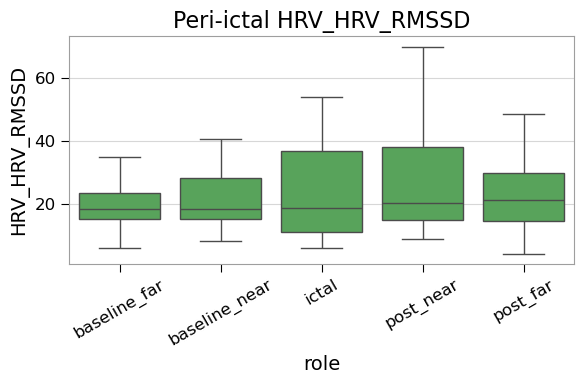

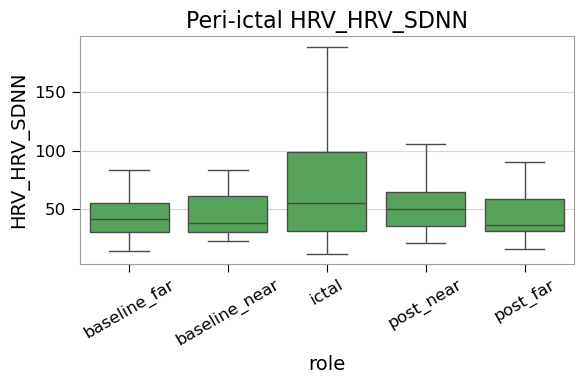

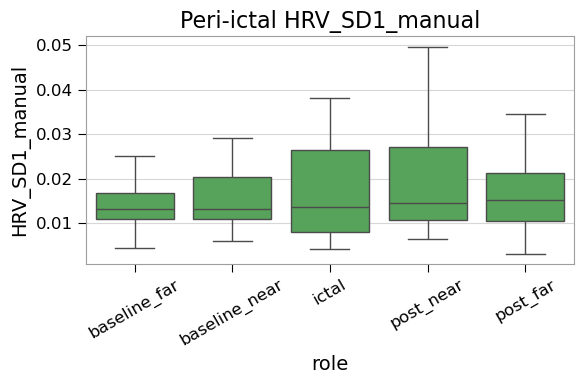

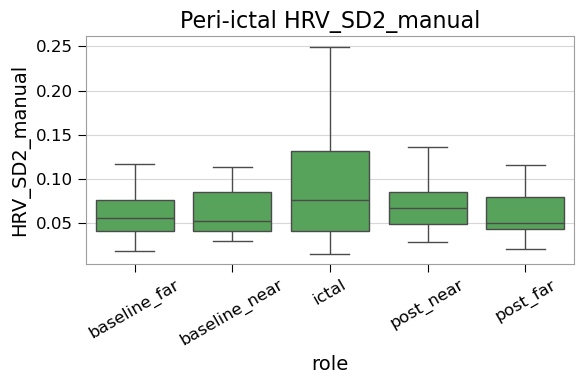

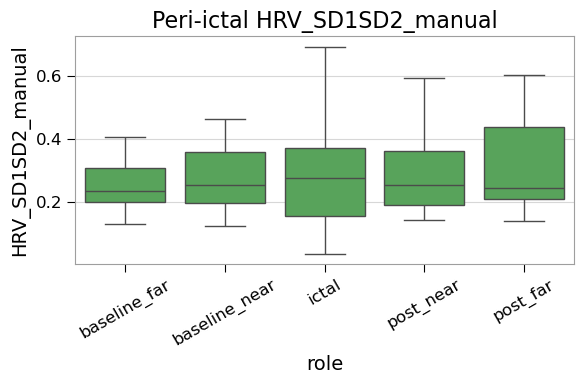

In [62]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_hrv_feature(feature: str):
    plt.figure(figsize=(6, 4))
    sns.boxplot(
        data=df_hrv_short,
        x="role",
        y=feature,
        order=roles_order,
        showfliers=False,
    )
    plt.title(f"Peri-ictal {feature}")
    plt.xticks(rotation=30)
    plt.tight_layout()
    plt.show()

# Eksempler:
plot_hrv_feature("HRV_HRV_RMSSD")
plot_hrv_feature("HRV_HRV_SDNN")
plot_hrv_feature("HRV_SD1_manual")
plot_hrv_feature("HRV_SD2_manual")
plot_hrv_feature("HRV_SD1SD2_manual")


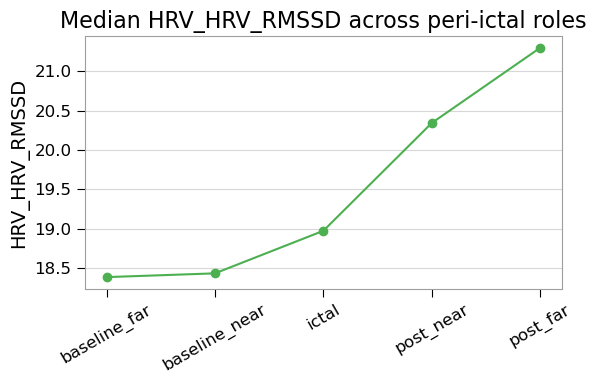

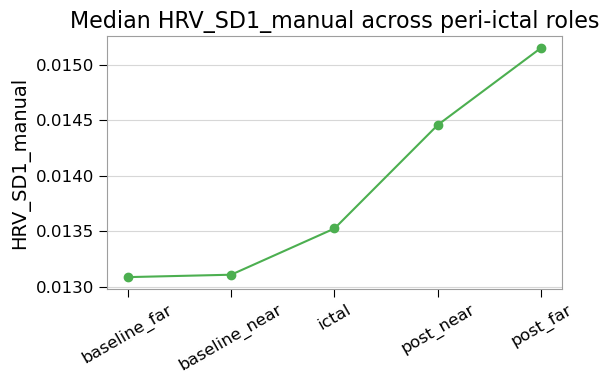

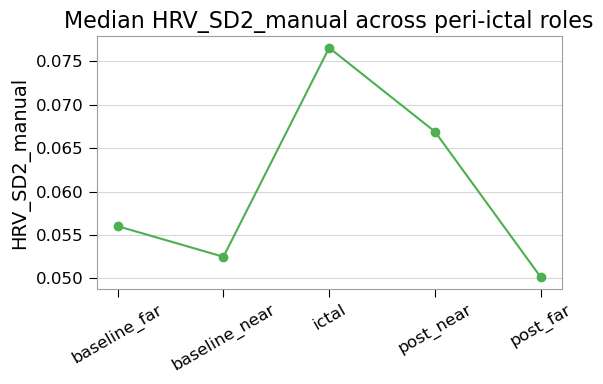

In [63]:
def plot_hrv_median_curve(feature: str):
    med = (
        df_hrv_short
        .groupby("role")[feature]
        .median()
        .reindex(roles_order)
    )

    plt.figure(figsize=(6, 4))
    plt.plot(roles_order, med.values, marker="o")
    plt.title(f"Median {feature} across peri-ictal roles")
    plt.ylabel(feature)
    plt.xticks(rotation=30)
    plt.tight_layout()
    plt.show()

plot_hrv_median_curve("HRV_HRV_RMSSD")
plot_hrv_median_curve("HRV_SD1_manual")
plot_hrv_median_curve("HRV_SD2_manual")


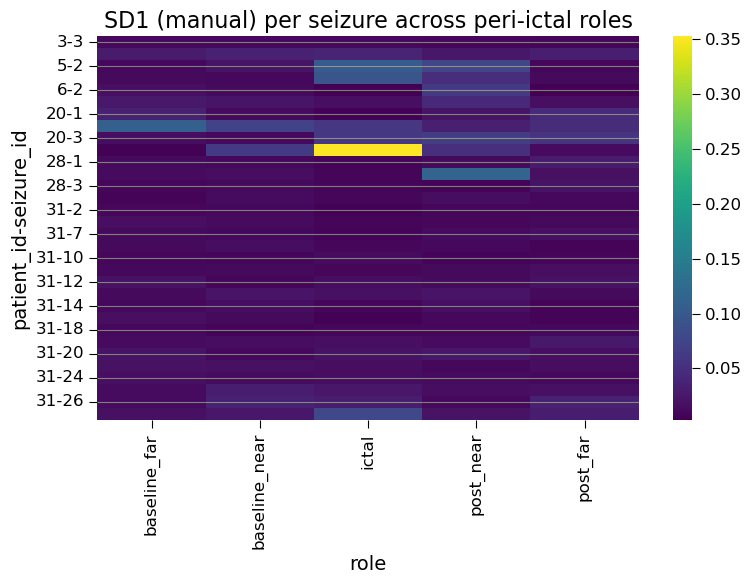

In [64]:
pivot_sd1 = df_hrv_short.pivot_table(
    index=["patient_id", "seizure_id"],
    columns="role",
    values="HRV_SD1_manual",        # "HRV_SD1_manual", "HRV_HRV_RMSSD","HRV_SD2_manual",
).reindex(columns=roles_order)

plt.figure(figsize=(8, 6))
sns.heatmap(pivot_sd1, cmap="viridis")
plt.title("SD1 (manual) per seizure across peri-ictal roles")
plt.tight_layout()
plt.show()


Merge HRV into df_all --> df_all_hrv

In [65]:
# Hvis du vil bruge den trimmede HRV-tabel:
df_hrv_short = df_hrv_full[
    ["recording_uid", "patient_id", "seizure_id", "role",
     "HRV_HRV_MeanNN", "HRV_HRV_SDNN", "HRV_HRV_RMSSD",
     "HRV_HRV_SDSD", "HRV_SD1_manual", "HRV_SD2_manual", "HRV_SD1SD2_manual"]
].copy()

df_all_hrv = pd.merge(
    df_all,
    df_hrv_short,
    on=["recording_uid", "patient_id", "seizure_id", "role"],
    how="left",
)

df_all_hrv.head()


,recording_uid,patient_id,seizure_id,role,rms,line_noise_ratio,hf_noise_ratio,snr_qrs,ulf_rel,qrs_rel,hf_rel,line_rel,ULF_power,LF_power,QRS-ish_power,HF(40-100)_power,Line(48-52)_power,ULF_rel,LF_rel,QRS-ish_rel,HF(40-100)_rel,Line(48-52)_rel,is_good,sqi_score,flag_amp_ok,flag_ramp_ok,flag_mean_freq_ok,flag_hf_rel_ok,flag_lf_rel_ok,flag_flat_ok,feat_ampdiff,feat_rampdiff,feat_mean_freq,feat_lf_power,feat_hf_power,feat_mains_power,feat_total_power,feat_lf_rel_power,feat_hf_rel_power,feat_mains_rel_power,feat_flat_rampdiff_min,feat_flat_rampdiff_p10,HRV_HRV_MeanNN,HRV_HRV_SDNN,HRV_HRV_RMSSD,HRV_HRV_SDSD,HRV_SD1_manual,HRV_SD2_manual,HRV_SD1SD2_manual
0,P03_R02,3,3,baseline_far,778.919764,0.000418,0.005702,0.085202,0.853611,0.078513,0.000448,0.000033,1.383429e+05,10908.509832,12724.387460,72.558761,5.315766,0.853611,0.067308,0.078513,0.000448,0.000033,True,1.0,True,True,True,True,True,True,5392.940749,4100.508858,2.254721,51531.412976,78.922426,2.838352,79105.716184,0.651425,0.000998,0.000036,391.312001,543.427652,857.648324,25.901465,15.032123,15.130501,0.010699,0.035033,0.305395
1,P03_R02,3,3,baseline_near,189.824165,0.000095,0.001634,1.097427,0.103485,0.523225,0.000855,0.000050,3.253964e+03,11703.932631,16452.197519,26.890124,1.570432,0.103485,0.372217,0.523225,0.000855,0.000050,True,1.0,True,True,True,True,True,True,1529.423667,1215.271778,6.802230,1339.992865,27.062786,0.738460,29521.810102,0.045390,0.000917,0.000025,804.669749,851.241389,895.823317,24.684240,14.654540,14.763180,0.010439,0.033311,0.313381
2,P03_R02,3,3,ictal,1903.275351,0.004982,0.048582,0.027766,0.867002,0.027016,0.001312,0.000135,1.286575e+06,154781.063218,40090.170958,1947.658699,199.725353,0.867002,0.104304,0.027016,0.001312,0.000135,True,1.0,True,True,True,True,True,True,11447.253895,6922.364416,1.313876,535941.409626,1719.609642,96.650101,787015.440661,0.680980,0.002185,0.000123,868.051270,1403.211768,501.498288,103.551201,16.515170,15.590193,0.011024,0.146028,0.075492
3,P03_R02,3,3,post_near,236.083768,0.000523,0.006228,0.935851,0.218931,0.483431,0.003011,0.000253,1.011393e+04,13577.258926,22332.978124,139.086948,11.671069,0.218931,0.293900,0.483431,0.003011,0.000253,True,1.0,True,True,True,True,True,True,2262.444739,1804.995499,6.891285,5347.329491,156.728281,5.503882,42241.376384,0.126590,0.003710,0.000130,788.135439,933.912938,730.883789,37.868283,13.193777,13.226487,0.009353,0.052731,0.177364
4,P03_R02,3,3,post_far,158.604714,0.000086,0.001455,1.161989,0.066637,0.537463,0.000782,0.000046,1.496716e+03,8869.113384,12071.717541,17.560866,1.041583,0.066637,0.394875,0.537463,0.000782,0.000046,True,1.0,True,True,True,True,True,True,1267.630426,1030.638651,6.917004,786.662688,17.825878,0.544705,21858.573903,0.035989,0.000816,0.000025,741.288228,779.317140,874.770221,25.149611,11.925837,12.010674,0.008493,0.034538,0.245898


In [66]:
OUT_DIR.mkdir(parents=True, exist_ok=True)
df_all_hrv.to_parquet(OUT_DIR / "study3_peri_features.parquet")
df_all_hrv.to_csv(OUT_DIR / "study3_peri_features.csv", index=False)

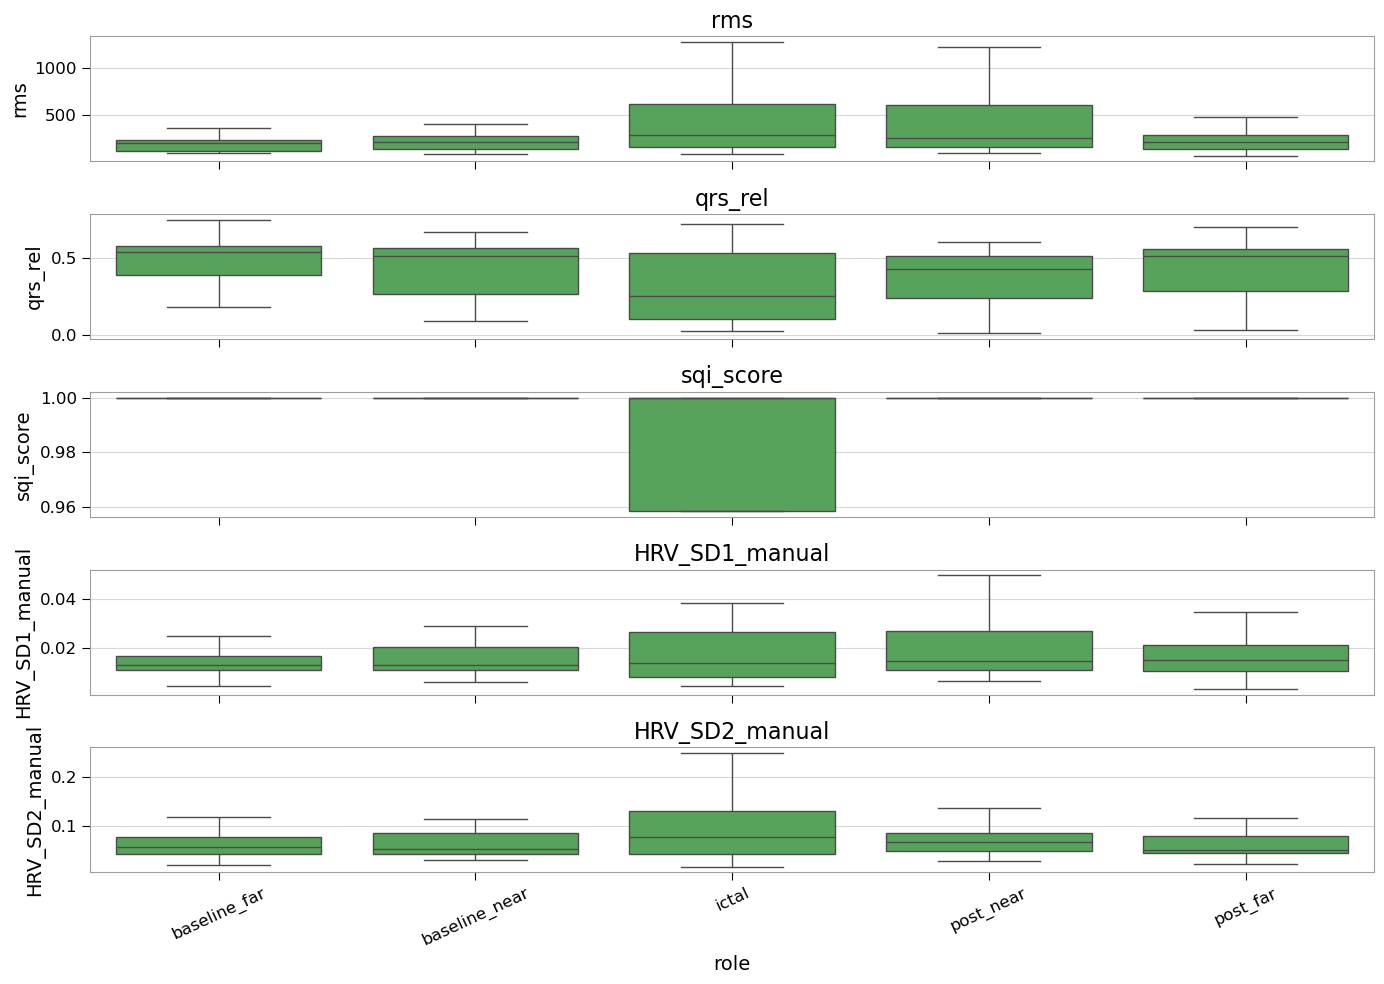

(<Figure size 1400x1000 with 5 Axes>,
 array([<Axes: title={'center': 'rms'}, xlabel='role', ylabel='rms'>,
        <Axes: title={'center': 'qrs_rel'}, xlabel='role', ylabel='qrs_rel'>,
        <Axes: title={'center': 'sqi_score'}, xlabel='role', ylabel='sqi_score'>,
        <Axes: title={'center': 'HRV_SD1_manual'}, xlabel='role', ylabel='HRV_SD1_manual'>,
        <Axes: title={'center': 'HRV_SD2_manual'}, xlabel='role', ylabel='HRV_SD2_manual'>],
       dtype=object))

In [67]:
from src.hrv_epatch.plots.peri_summary import plot_peri_summary, plot_peri_median_curves

selected_features = [
    "rms",            # noise metric
    "qrs_rel",        # PSD / morphology
    "sqi_score",      # signal quality
    "HRV_SD1_manual", # HRV (short-term variability)
    "HRV_SD2_manual"
]

plot_peri_summary(df_all_hrv, selected_features)


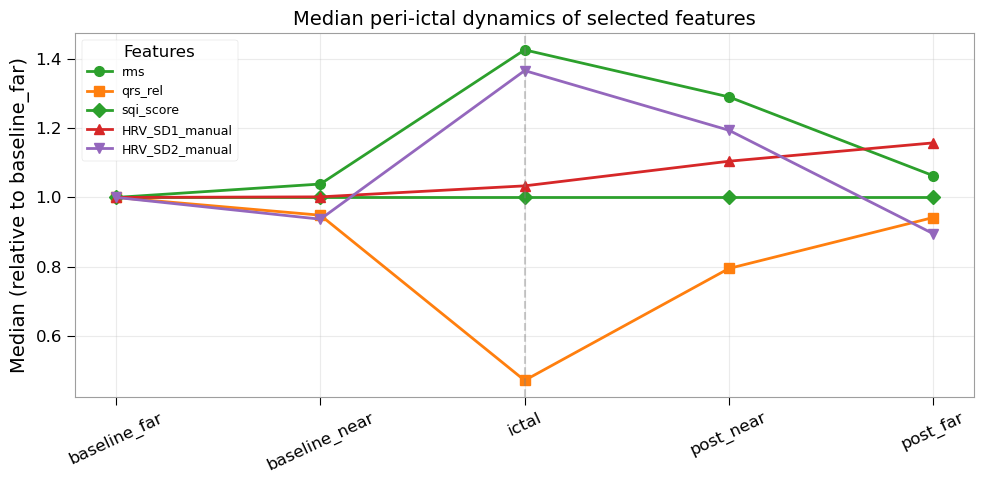

In [68]:
selected_features = ["rms", "qrs_rel", "sqi_score", "HRV_SD1_manual", "HRV_SD2_manual"]
plot_peri_median_curves(df_all_hrv, selected_features, figsize=(10,5))


Peri-ictal RMS values increased sharply during ictal periods, with both median and mean values peaking substantially in the ictal window.
The difference between median and mean indicates the presence of high-amplitude artefacts (e.g., muscle activation) during seizures.

Short-term HRV metrics (SD1, SD2) were consistently lower during ictal periods, suggesting reduced short-term autonomic variability during the seizure itself.

The ictal window contains a small number of extreme values (artefacts),visible in the mean curve, but largely suppressed in the median curve.

c:\Users\kvjkv\.vscode\Epilepsy_MasterThesis\src\hrv_epatch\plots\peri_wavelet.py:88: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


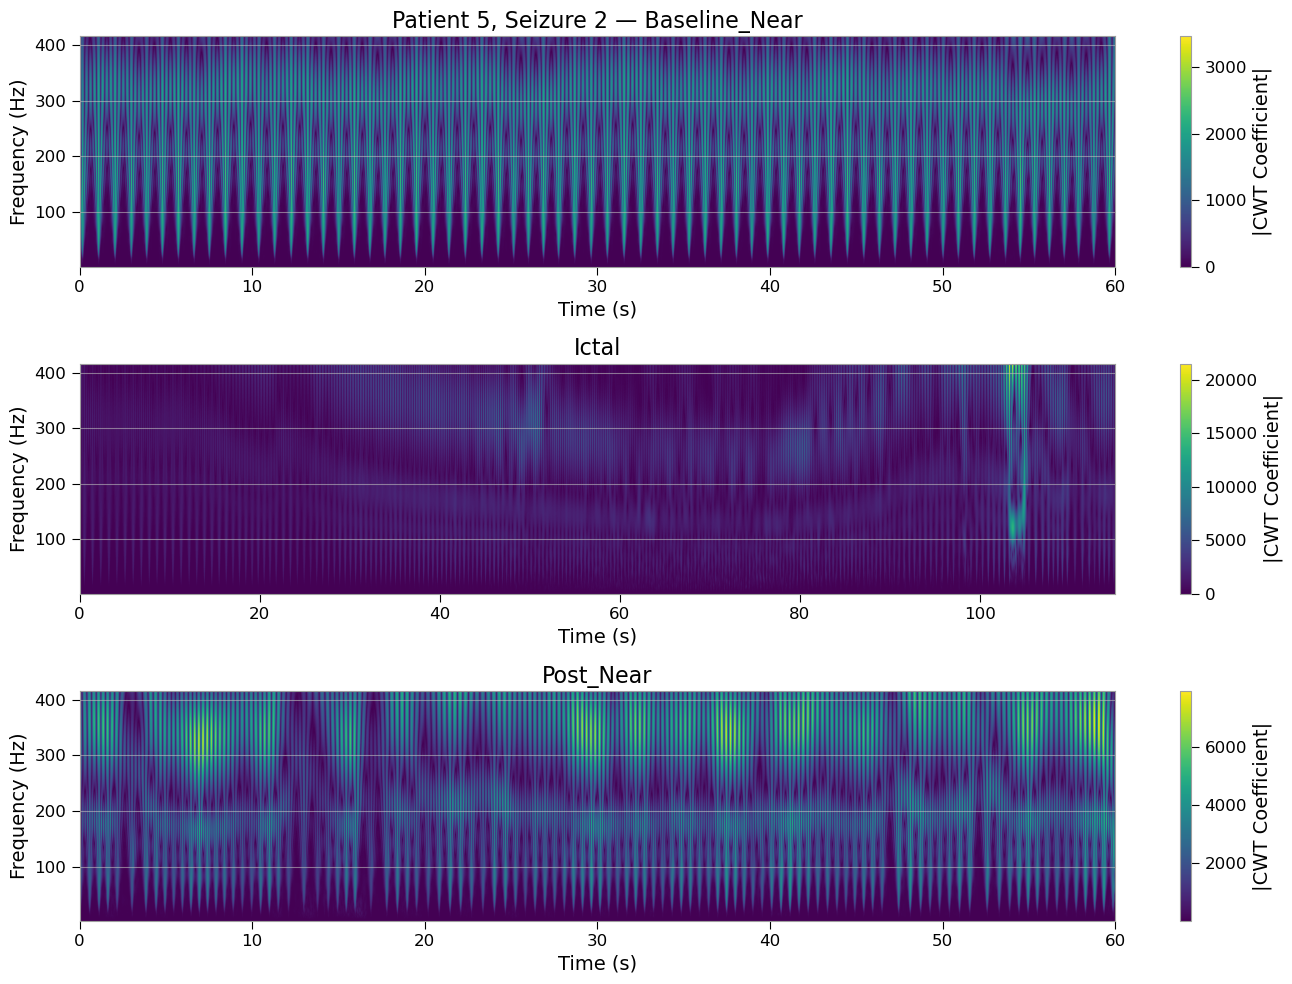

In [70]:
from src.hrv_epatch.plots.peri_wavelet import plot_peri_cwt_triplet

fs = 512.0
plot_peri_cwt_triplet(df_peri_valid, fs, patient_id=5, seizure_id=2)


Explorativ CWT walkthroug.

In [ ]:
# from src.hrv_epatch.plots.peri_wavelet import plot_peri_cwt_triplet

# fs = 512.0

# unique_seizures = (
#     df_peri_valid[["patient_id", "seizure_id"]]
#     .drop_duplicates()
#     .sort_values(["patient_id", "seizure_id"])
# )

# for _, row in unique_seizures.iterrows():
#     pid = row["patient_id"]
#     sid = row["seizure_id"]
#     print(f"Plotting Patient {pid}, Seizure {sid}")
#     try:
#         plot_peri_cwt_triplet(df_peri_valid, fs, patient_id=pid, seizure_id=sid)
#     except ValueError as e:
#         print("  Skipping:", e)
#         continue
    
#     # stop manuelt hvis du vil:
#     cont = input("Næste? (Enter = ja, q = stop) ")
#     if cont.lower().startswith("q"):
#         break


Alternative CWT analysis for all seizures in all patients and save local.

In [ ]:
from pathlib import Path
from src.hrv_epatch.plots.peri_wavelet import plot_peri_cwt_triplet
from src.hrv_epatch.plots.peri_wavelet_dwt import plot_dwt_triplet

OUT_ROOT = Path(r"E:\Speciale - Results")
OUT_CWT = OUT_ROOT / "cwt_peri"
OUT_DWT = OUT_ROOT / "dwt_peri"
OUT_CWT.mkdir(parents=True, exist_ok=True)
OUT_DWT.mkdir(parents=True, exist_ok=True)

fs = 512.0  # eller df_peri_valid["fs"].iloc[0] hvis du vil læse dynamisk

# Unikke (patient, seizure)-par
unique_seizures = (
    df_peri_valid[["patient_id", "seizure_id"]]
    .drop_duplicates()
    .sort_values(["patient_id", "seizure_id"])
)

print(f"Processing {len(unique_seizures)} seizures...\n")

for _, row in unique_seizures.iterrows():
    pid = int(row["patient_id"])
    sid = int(row["seizure_id"])

    print(f"P{pid:02d} S{sid:02d} ... ", end="")

    # Filnavne
    cwt_path = OUT_CWT / f"CWT_P{pid:02d}_S{sid:02d}.png"
    dwt_path = OUT_DWT / f"DWT_P{pid:02d}_S{sid:02d}.png"

    try:
        # CWT-triple (baseline_near, ictal, post_near)
        plot_peri_cwt_triplet(
            df_peri=df_peri_valid,
            fs=fs,
            patient_id=pid,
            seizure_id=sid,
            save_path=cwt_path,
            show_plot=False,   # <- ingen visning
        )

        # DWT-triple (samme vinduer)
        plot_dwt_triplet(
            df_peri=df_peri_valid,
            fs=fs,
            patient_id=pid,
            seizure_id=sid,
            save_path=dwt_path,
            show_plot=False,   # <- ingen visning
        )

        print("saved.")
    except Exception as e:
        print(f"skipped ({e}).")

print("\nDone.")


Processing 146 seizures...

P01 S01 ... saved.
P01 S02 ... saved.
P01 S03 ... saved.
P02 S01 ... saved.
P02 S02 ... saved.
P02 S03 ... saved.
P02 S04 ... saved.
P02 S05 ... saved.
P02 S07 ... saved.
P02 S08 ... saved.
P02 S09 ... saved.
P02 S10 ... saved.
P03 S01 ... saved.
P03 S02 ... saved.
P03 S03 ... saved.
P04 S01 ... saved.
P05 S01 ... saved.
P05 S02 ... saved.
P05 S03 ... saved.
P06 S02 ... saved.
P07 S01 ... saved.
P07 S02 ... saved.
P07 S03 ... saved.
P07 S04 ... saved.
P08 S01 ... saved.
P09 S01 ... saved.
P09 S02 ... saved.
P09 S03 ... saved.
P10 S01 ... saved.
P11 S01 ... saved.
P11 S02 ... saved.
P11 S03 ... saved.
P11 S04 ... saved.
P11 S05 ... saved.
P11 S06 ... saved.
P12 S01 ... saved.
P12 S02 ... saved.
P12 S03 ... saved.
P13 S01 ... saved.
P13 S02 ... saved.
P13 S03 ... saved.
P13 S04 ... saved.
P13 S05 ... saved.
P13 S06 ... saved.
P13 S15 ... saved.
P13 S25 ... saved.
P14 S01 ... saved.
P14 S02 ... saved.
P14 S03 ... saved.
P14 S04 ... saved.
P14 S05 ... saved.
P14

## 8. Noise and spectral characteristics

We complement the SQI analysis with PSD-based noise metrics and bandpower
profiles for selected segments / patients.

## 9. Peri-ictal windows around seizures

In addition to the global 60 s segmentation, we construct peri-ictal windows
around each seizure to study how signal characteristics change before, during,
and after clinical events.

We reuse the previous scheme:
- seizure-only windows (matching seizure duration)
- seizure ±2 minutes
- “clean” baseline windows ~20 minutes before seizure

## 10. Case-study plots

Finally, we generate a small number of illustrative plots for selected seizures:
- raw vs cleaned ECG with R-peaks from different detectors
- peri-ictal scalograms / PSD
- segment-level SQI and noise metrics across time

## 11. Export of tables and figures

We finally export the key tables and figures used in the thesis, so that the
LaTeX document can include them directly.